In [18]:
#Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.keras.backend.clear_session()

#Check version
print('tensorflow version:',tf.__version__)

tensorflow version: 2.5.0


In [19]:
#Load Fashion MNIST dataset

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train = len(train_images)
size_of_test = len(test_images)
num_of_class = 10

print("The number of train images:",size_of_train)
print("The number of test images:",size_of_test)


The number of train images: 60000
The number of test images: 10000


In [20]:

print('==Before normalization==')
print('Image Shape:',train_images.shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(
    np.min(train_images[0]),np.mean(train_images[0]),np.max(train_images[0])))
print(train_labels)

##Dataset Pre-processing##
#Normalization
train_images= train_images/255.
test_images =test_images/255.

#Reshape(Adding chaneel)
train_images = train_images.reshape((size_of_train,28,28,1))
test_images = test_images.reshape((size_of_test,28,28,1))

#Convet label
train_labels = tf.keras.utils.to_categorical(train_labels,num_of_class)
test_labels = tf.keras.utils.to_categorical(test_labels,num_of_class)

print('==Afte normalization==')
print('Image Shape:',train_images.shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(
    np.min(train_images[0]),np.mean(train_images[0]),np.max(train_images[0])))
print(train_labels)


==Before normalization==
Image Shape: (60000, 28, 28)
Value MIN: 0, MEAN:97.25, MAX:255
[9 0 0 ... 3 0 5]
==Afte normalization==
Image Shape: (60000, 28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
#Define blocks
def channel_attention(x, filter):

    dense_1 = tf.keras.layers.AveragePooling2D(pool_size=(1, 1))
    dense_2 = tf.keras.layers.Dense(filter/4, activation='relu') 
    dense_3 = tf.keras.layers.Dense(filter, activation='sigmoid') 

    x1 = dense_1(x)
    x1 = dense_2(x1)
    x1 = dense_3(x1)
    # x = x * x1
    x = tf.multiply(x, x1)
    return x

def spatial_attention(x):
    
    conv_1 = tf.keras.layers.Conv1D(filters=1, kernel_size=3, padding="same" ,activation='sigmoid') 
    
    x1 = conv_1(x)
    # x = x * x1
    x = tf.multiply(x, x1)
    return  x


def attention_module(x, filter, attention_type):

    if attention_type is 'channel':
        # Channel Attnetion only
        x = channel_attention(x,filter)
        output = x
        
    elif attention_type is 'spatial':
        # Spatial Attention only
        x = spatial_attention(x)
        output = x

    elif attention_type is 'parellel_add':
        x = channel_attention(x,filter) + spatial_attention(x)
        output = x

    elif attention_type is 'parellel_mul':
        # Parelle Attention (Mul)
        x = channel_attention(x,filter) * spatial_attention(x)
        output = x


    elif attention_type is 'serial_ca':
        # Serial Attention, CA first
        x = channel_attention(x,filter)
        x = spatial_attention(x)
        output = x

    elif attention_type is 'serial_sa':
        # Serial Attention, SA first
        x = spatial_attention(x)
        x = channel_attention(x,filter)
        output = x

    else:
        output  = x
    
    return output


def res_block(x,filter,stride,name):
    input = x
    if stride != 1:
        input = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=stride,name=name+'_pooling_conv')(input)
        input = tf.keras.layers.BatchNormalization(name=name+'_pooling_bn')(input)

    x = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=stride,padding='same',name=name+'_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn1')(x)
    x = tf.nn.relu(x,name=name+'_relu1')

    x = tf.keras.layers.Conv2D(filters=filter,kernel_size=1,strides=1,padding='same',name=name+'_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn2')(x)
    x = tf.keras.layers.add([input,x],name=name+'_add')

    x = tf.nn.relu(x,name=name+'_relu2')
    return x




def model_builder(x,attention):
    #######################
    #Add Attention Module #
    
    x = tf.keras.layers.Conv2D(filters=64,kernel_size=7,strides=2,activation='relu',padding='same',name='conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='conv1_bn')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same',name='conv1_max_pool')(x)

    x = res_block(x,64,2,'ResBlock21') 
    x = attention_module(x,filter = 64,attention_type = attention)

    x = res_block(x,64,1,'ResBlock22')
    x = attention_module(x,filter = 64,attention_type = attention)

    x = res_block(x,128,2,'ResBlock31')
    x = attention_module(x,filter = 128,attention_type = attention)

    x = res_block(x,128,1,'ResBlock32')
    x = attention_module(x,filter = 128,attention_type = attention)

    x =tf.keras.layers.GlobalAveragePooling2D(name='GAP')(x) 
    pred = tf.keras.layers.Dense(num_of_class,activation='softmax')(x)
    
    return pred


inputs = tf.keras.Input(shape=(28,28,1))

pred_normal = model_builder(inputs,None)

pred_channel = model_builder(inputs,attention='channel')
pred_spatial = model_builder(inputs,attention='spatial')

pred_parellel_add = model_builder(inputs,attention='parellel_add')
pred_parellel_mul = model_builder(inputs,attention='parellel_mul')

pred_serial_ca = model_builder(inputs,attention='serial_ca')
pred_serial_sa = model_builder(inputs,attention='serial_sa')


model_normal = tf.keras.Model(inputs=inputs,outputs=pred_normal)
model_channel = tf.keras.Model(inputs=inputs,outputs=pred_channel)
model_spatial = tf.keras.Model(inputs=inputs,outputs=pred_spatial)
model_parellel_add = tf.keras.Model(inputs=inputs,outputs=pred_parellel_add)
model_parellel_mul = tf.keras.Model(inputs=inputs,outputs=pred_parellel_mul)
model_serial_ca = tf.keras.Model(inputs=inputs,outputs=pred_serial_ca)
model_serial_sa = tf.keras.Model(inputs=inputs,outputs=pred_serial_sa)

model_normal.summary()
model_channel.summary()
model_spatial.summary()
model_parellel_add.summary()
model_parellel_mul.summary()
model_serial_ca.summary()
model_serial_sa.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_max_pool (MaxPooling2D)   (None, 7, 7, 64)     0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [22]:
#Select optimizer and compile Model
optimizer = tf.keras.optimizers.Adam()
model_normal.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_channel.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_spatial.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_parellel_add.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_parellel_mul.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_serial_ca.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_serial_sa.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])


In [23]:
#Train Normal Model
print('Training Normal Model')
hist_normal = model_normal.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Channel Attention Model
print('Training Channel Attention Model')
hist_channel = model_channel.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Spatial Attention Model
print('Training Spatial Attention Model')
hist_spatial = model_spatial.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Parelle add  Model
print('Training Parelle add  Model')
hist_parellel_add = model_parellel_add.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Parellel Mul Model
print('Training  Parellel Mul Model')
hist_parellel_mul = model_parellel_mul.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Serial CA Model
print('Training Serial CA Model')
hist_serial_ca = model_serial_ca.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))

#Train Serial SA Model
print('Training Serial SA Model')
hist_serial_sa = model_serial_sa.fit(train_images,train_labels,
                    batch_size=16,
                    epochs=30,
                    shuffle=True,
                    validation_data=(test_images,test_labels))



Training Normal Model
Epoch 1/30
3750/3750 [==============================] - 38s 10ms/step - loss: 0.5490 - accuracy: 0.7985 - val_loss: 0.4760 - val_accuracy: 0.8239
Epoch 2/30
3750/3750 [==============================] - 34s 9ms/step - loss: 0.4282 - accuracy: 0.8420 - val_loss: 0.4383 - val_accuracy: 0.8418
Epoch 3/30
3750/3750 [==============================] - 34s 9ms/step - loss: 0.3913 - accuracy: 0.8550 - val_loss: 0.4155 - val_accuracy: 0.8452
Epoch 4/30
3750/3750 [==============================] - 34s 9ms/step - loss: 0.3672 - accuracy: 0.8637 - val_loss: 0.4974 - val_accuracy: 0.8186
Epoch 5/30
3750/3750 [==============================] - 34s 9ms/step - loss: 0.3489 - accuracy: 0.8703 - val_loss: 0.3928 - val_accuracy: 0.8557
Epoch 6/30
3750/3750 [==============================] - 35s 9ms/step - loss: 0.3335 - accuracy: 0.8761 - val_loss: 0.3805 - val_accuracy: 0.8607
Epoch 7/30
3750/3750 [==============================] - 35s 9ms/step - loss: 0.3229 - accuracy: 0.8798 - va

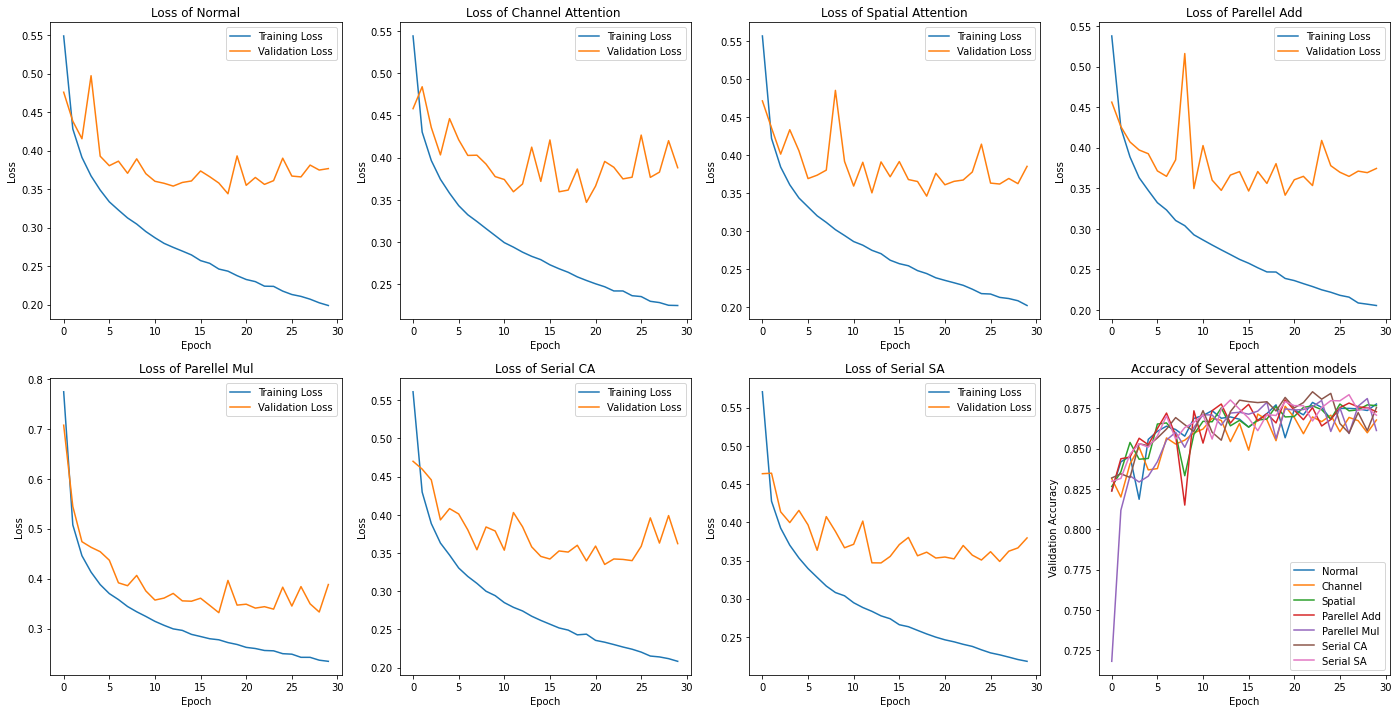

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
plt.plot(hist_normal.history['loss'])
plt.plot(hist_normal.history['val_loss'])
plt.title('Loss of Normal')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(hist_channel.history['loss'])
plt.plot(hist_channel.history['val_loss'])
plt.title('Loss of Channel Attention ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(hist_spatial.history['loss'])
plt.plot(hist_spatial.history['val_loss'])
plt.title('Loss of Spatial Attention')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(hist_parellel_add.history['loss'])
plt.plot(hist_parellel_add.history['val_loss'])
plt.title('Loss of Parellel Add')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(hist_parellel_mul.history['loss'])
plt.plot(hist_parellel_mul.history['val_loss'])
plt.title('Loss of Parellel Mul')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,6)
plt.plot(hist_serial_ca.history['loss'])
plt.plot(hist_serial_ca.history['val_loss'])
plt.title('Loss of Serial CA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,7)
plt.plot(hist_serial_sa.history['loss'])
plt.plot(hist_serial_sa.history['val_loss'])
plt.title('Loss of Serial SA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,8)
plt.plot(hist_normal.history['val_accuracy'])
plt.plot(hist_channel.history['val_accuracy'])
plt.plot(hist_spatial.history['val_accuracy'])
plt.plot(hist_parellel_add.history['val_accuracy'])
plt.plot(hist_parellel_mul.history['val_accuracy'])
plt.plot(hist_serial_ca.history['val_accuracy'])
plt.plot(hist_serial_sa.history['val_accuracy'])

plt.title('Accuracy of Several attention models')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel','Spatial','Parellel Add','Parellel Mul','Serial CA','Serial SA'], loc=0)

plt.show()